# Predicting helpful reviews using machine learning and specifical classification
----------------------
## Problem
### It has been showed that over last past 10 years, global retail e-commerce has been explosive growth. Without experience of product commonalities, customers will heavily rely on other reviewers for the decision making for the online shopping. However, with amount of information from reviewers, it is important for a website to identify the useful, valid, and reliable reviews to save help customers. Useful reviews also can in turn to help business to improve their products and understand customers' need.

## Goal
### The goal of this project is to mine 9,000,000 million book reviews from Amazon.com to understand the features of reviews for helpfulness and develop preliminary classification models to predict helpfulness of a review foods


## Data source
### http://jmcauley.ucsd.edu/data/amazon/
#### Data information
    "reviewerID": "A2SUAM1J3GNN3B"
    "asin": "0000013714"
    "reviewerName": "J. McDonald"
    "helpful": [2, 3]
    "reviewText": "Great purchase though!",
    "overall": 5.0,
    "summary": "Heavenly Highway Hymns",
    "unixReviewTime": 1252800000,
    "reviewTime": "09 13, 2009"

-------------------------------------------------
## _1. Preparing Amazon book dataset_

### 1.1. Load json data from bigquery ( here we imported ~100,000 data)
### 1.2. Check data
### 1.3. Label sentiment of reviewer rating for a product
        rating as 1 and 2 ==> negative
        rating as 3       ==> neural
        rating as 4 and 5 ==> positive
### 1.4. Label helpful and unhelpful reviews
        helful_vot/total vot > 75% ==> helpfulness 
        helful_vot/total vot <= 75% ==> unhelpfulness

In [3]:
##########################################
## 1.1 CONFIG FOR BIGQUERY
##########################################

## Setting configuration for bigquery
## Save data as dataframe 

from bigquery import get_client

# BigQuery project id as listed in the Google Developers Console.
project_id = 'springboard-project'

# Service account email address as listed in the Google Developers Console.
service_account = 'python-pandas@springboard-project.iam.gserviceaccount.com'

# PKCS12 or PEM key provided by Google.
key = '/Users/tancy/SpringBoardProject-b3a58f067389.p12'

client = get_client(project_id, service_account=service_account,
                    private_key_file=key, readonly=True)

In [4]:
##########################################
## BIGQUERY TO DATAFRAME
##########################################

import pandas as pd

# to communicate with Google BigQuery
from pandas.io import gbq

amazon_book_sample_query = """
SELECT
    reviewerID,
    asin,
    unixReviewTime,
    overall,
    reviewText,
    summary,
    helpful_vot,
    tot_vot,

FROM
    (SELECT * FROM [springboard-project:AmazonReview.book2_small_sample])
    
"""

try:
    ABS_df = gbq.read_gbq(amazon_book_sample_query, project_id=project_id)
except:
    print 'Error reading the dataset'


Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 1; 12.0% done. Elapsed 35.83 s.
  Got page: 2; 23.0% done. Elapsed 52.51 s.
  Got page: 3; 34.0% done. Elapsed 62.27 s.
  Got page: 4; 46.0% done. Elapsed 70.92 s.
  Got page: 5; 57.0% done. Elapsed 79.49 s.
  Got page: 6; 69.0% done. Elapsed 88.03 s.
  Got page: 7; 80.0% done. Elapsed 102.6 s.
  Got page: 8; 92.0% done. Elapsed 117.92 s.
  Got page: 9; 100.0% done. Elapsed 125.1 s.
Got 100225 rows.

Total time taken 129.43 s.
Finished at 2016-11-30 15:27:24.


In [5]:
##########################################
## 1.2 CHECK DATA IN PANDAS
############################################

# change column name 
ABS_df = ABS_df.rename(columns={'overall': 'reviewRating'})

print "Total data:", str(ABS_df.shape)
ABS_df.head(2)


Total data: (100225, 8)


,reviewerID,asin,unixReviewTime,reviewRating,reviewText,summary,helpful_vot,tot_vot
0,A2Y18PKYE2B11Z,1495925927,1402531200,5,"This book is beautifully written, Phoenix and ...",AN ABSOLUTELY WONDERFUL LOVE STORY,1,1
1,A33N05GF31KN8N,9652294802,1273536000,4,Disclaimer: I got this book as an ARC in excha...,A Wonderful Message,1,1


### Here, we randomly selected ~100,000 reviews (1%) from total amazon book reviews

In [6]:
##########################################
## 1.3 LABEL SENTIMENT OF REVIEW
##########################################

def label_Sentiment(row):
    if row['reviewRating'] <= 2:
           return "negative"
    if row['reviewRating'] == 3:
           return "neural"
    if row['reviewRating'] >= 4:
           return "positive"

ABS_df['sentiment'] = ABS_df.apply(label_Sentiment, axis=1)


In [7]:
##########################################
## 1.4 LABEL HELPFULNESS
#########################################
import numpy as np

def label_Helpfulness(row):
    if row['help_prop'] > 0.75:
           return 'helpful'
    else: 
           return 'unhelpful'

ABS_df['help_prop'] = ABS_df.helpful_vot.div(ABS_df.tot_vot, axis=0)
#ABS_df = ABS_df[np.isfinite(ABS_df['help_prop'])] ### should we exclude reviews with no vote ? ###
ABS_df['helpIndx'] = ABS_df.apply(label_Helpfulness, axis=1)

ABS_df.head(2)

,reviewerID,asin,unixReviewTime,reviewRating,reviewText,summary,helpful_vot,tot_vot,sentiment,help_prop,helpIndx
0,A2Y18PKYE2B11Z,1495925927,1402531200,5,"This book is beautifully written, Phoenix and ...",AN ABSOLUTELY WONDERFUL LOVE STORY,1,1,positive,1.0,helpful
1,A33N05GF31KN8N,9652294802,1273536000,4,Disclaimer: I got this book as an ARC in excha...,A Wonderful Message,1,1,positive,1.0,helpful


-----------------
## _2. Preliminary Analysis_
### 2.1 Descriptive statistics
### 2.2 Distribution of reviewer rating (1 to 5)
### 2.3 Distribution of helful proportion for reviews
### 2.4 Distribution of reviewer rating for helpfulness
### 2.5 An example of a product for reviewer rating and helpfulness
### 2.6 Helpfulness for the length of text

In [8]:
##########################################
## 2.1 DESCRIPTIVE STATISTICS
##########################################

print "================================================"

### Total reviews
print "Number of reviews:" + str(len(ABS_df))

### How many unique reviewers?
reviewer_prop = float(len(ABS_df.reviewerID.unique()))/len(ABS_df.index)
print "Prop of unique reviewers:" + str(round(reviewer_prop,3))

### How many unique products?
product_prop = float(len(ABS_df.asin.unique()))/len(ABS_df.index)
print "Prop of unique products:" + str(round(product_prop,3))

### average star score
print("Average rating score: " + str(round(ABS_df.reviewRating.mean(),3)))

### average helpful 
print("Average helpful pcd:" + str(round(ABS_df.help_prop.mean(),3)))
print "================================================"

Number of reviews:100225
Prop of unique reviewers:0.768
Prop of unique products:0.666
Average rating score: 4.251
Average helpful pcd:0.734


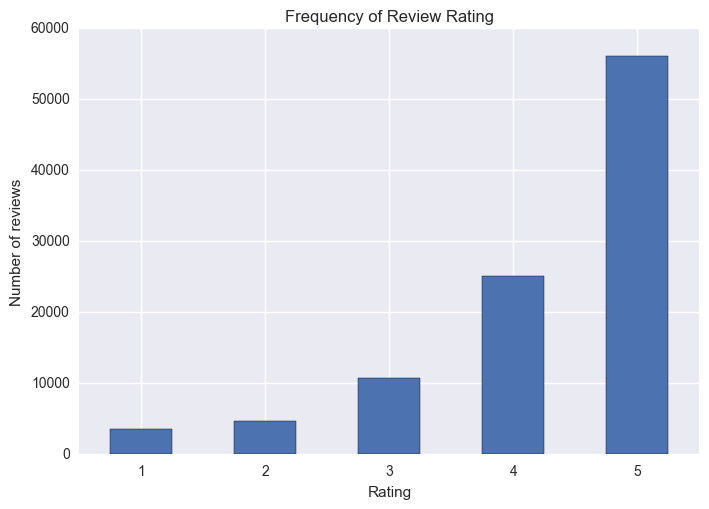

In [9]:
##########################################
## 2.2 DISTRIBUTION OF REVIEWER RATING
########################################## 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

ABS_df.groupby('reviewRating').size().plot(kind='bar')
plt.title("Frequency of Review Rating")
plt.xlabel("Rating")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()

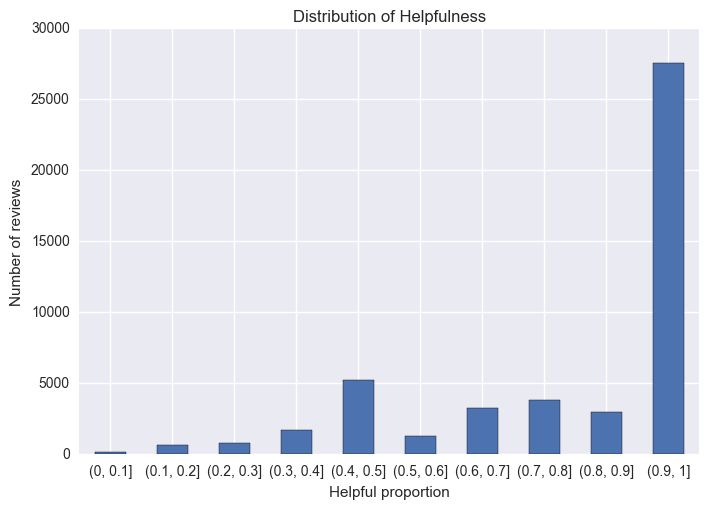

In [10]:
##########################################
## 2.3 DISTRIBUTION OF HELPFULNESS
########################################## 

cutoff = np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])


Dist_help = ABS_df.groupby([pd.cut(ABS_df['help_prop'], bins = cutoff)]).size()
Dist_help.plot(kind='bar')

plt.title("Distribution of Helpfulness")
plt.xlabel("Helpful proportion")
plt.ylabel("Number of reviews")
plt.xticks(rotation=0)
plt.show()

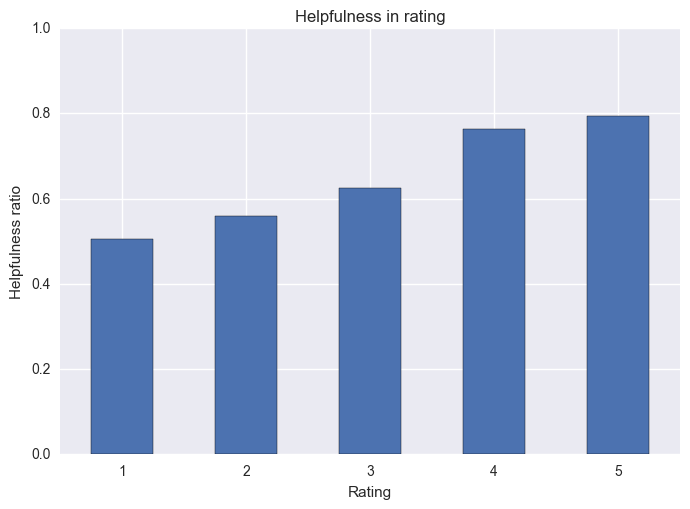

In [11]:
##########################################
## 2.4 DISTRIBUTION OF RATING FOR HELPFULNESS
########################################## 
ABS_df.groupby('reviewRating')['help_prop'].mean().plot(kind='bar')
plt.title("Helpfulness in rating")
plt.xlabel("Rating")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])
plt.xticks(rotation=0)
plt.show()

### ==> preliminary result showed the customers have tendency to vote more helpfulness for higher rating reviews. 

In [12]:
##########################################
## 2.5 A PRODUCT FOR REVIEWER RATING AND HELPFULNESS
########################################## 
ABS_df.groupby('asin').size().sort_values(ascending=False).head(5)

asin
0439023483    84
030758836X    77
0375831002    63
0385537859    59
038536315X    56
dtype: int64

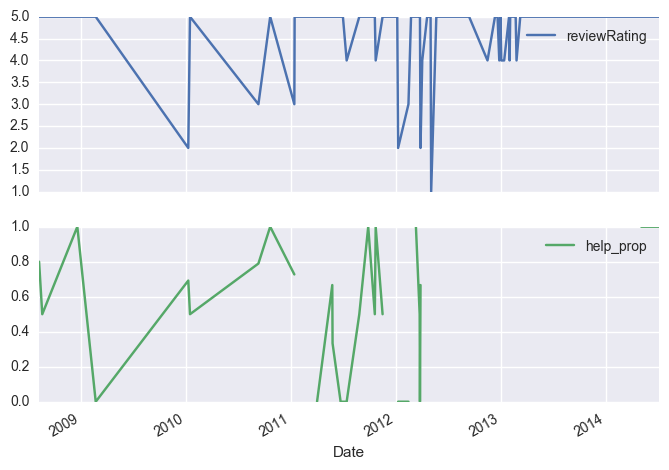

In [13]:
import warnings
warnings.filterwarnings('ignore')

OneProduct = ABS_df[ABS_df.asin=='0439023483']
OneProduct['Date'] = pd.to_datetime(OneProduct['unixReviewTime'],unit='s')
OneProduct_mean = OneProduct.groupby("Date")['reviewRating','help_prop'].mean()
#OneProduct_mean.head()
OneProduct_mean.plot(subplots=True)
plt.show()

### ==> from single product, it seems the helpful proportion may not affect by the history of review rating 

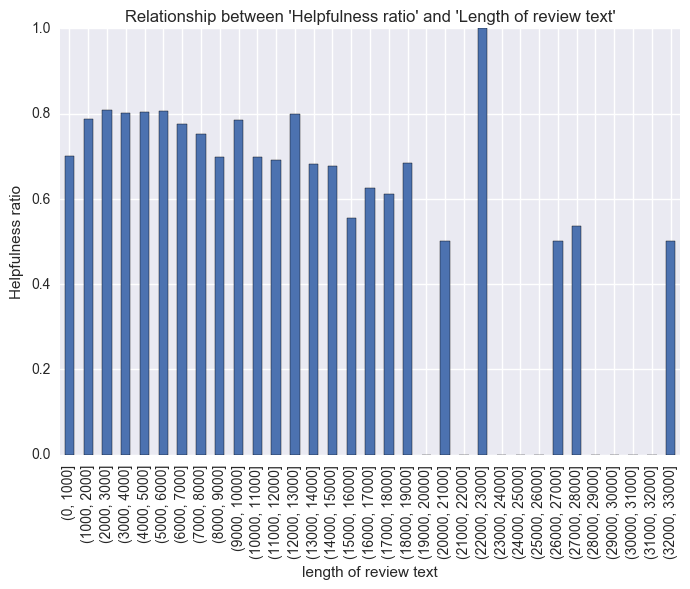

In [14]:
##########################################
## 2.6 HELPFULNESS FOR LENGTH OF TEXT
########################################## 
ABS_df['text_len'] = ABS_df.reviewText.apply(len)
maxTextLen = max(ABS_df.text_len)
ABS_df.groupby(pd.cut(ABS_df['text_len'], np.arange(0,maxTextLen+1000,1000)))['help_prop'].mean().plot(kind='bar')
plt.xlabel("length of review text")
plt.ylabel("Helpfulness ratio")
plt.title("Relationship between 'Helpfulness ratio' and 'Length of review text'")
plt.ylim([0, 1])

plt.show()

### ==> considering all data, it seems that helpfulness for a review increased to 80% when text length increased to 2000. When the text length more than 6000, the helpfulness decreased. 

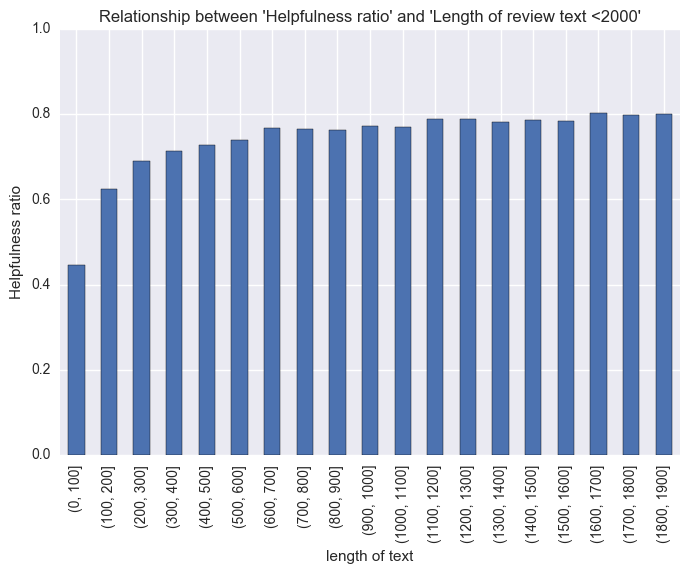

In [15]:
## check helpfulness ration below 2000 words
ABS_df['text_len'] = ABS_df.reviewText.apply(len)
maxTextLen = 2000 ## 
ABS_df.groupby(pd.cut(ABS_df['text_len'], np.arange(0,maxTextLen,100)))['help_prop'].mean().plot(kind='bar')
plt.xlabel("length of text")
plt.ylabel("Helpfulness ratio")
plt.ylim([0, 1])
plt.title("Relationship between 'Helpfulness ratio' and 'Length of review text <2000'")
plt.show()

### ==> Specifically, helpfulness increased to 80% when text length increased to 700. After 700 words, there is no difference of the helpfulness ratio.

-----------
## _3. Text Preprocessing_
### 3.1 Subset data for modeling
        total vote >=2 & text_len >=2
### 3.2 Statistic description of subset data 
### 3.3 Text length between helpfulness and unhelpfulness
### 3.4 Pair correlation between 'reviewRating','help_prop','helpful_vot','text_len','tot_vot','helpIndx'

In [16]:
###################
## 3.1 SUBSET DATA
###################

## select total vote >= 2
subset_ABS_df = ABS_df[(ABS_df.tot_vot>=2) & (ABS_df.text_len>=2)]

class_counts = subset_ABS_df.groupby('helpIndx').size()
help_proportion = round(class_counts[0]/float(class_counts.sum()),3)
unhelp_proportion = round(class_counts[1]/float(class_counts.sum()),3)

print "==========================================================="
print "Number of helpfulness (>75%) {}, proportion is {}".format(class_counts[0], help_proportion)
print "Number of unhelpfulness      {}, proportion is {}".format(class_counts[1], unhelp_proportion)
print "=========================================================="


Number of helpfulness (>75%) 17864, proportion is 0.513
Number of unhelpfulness      16948, proportion is 0.487


### ==> the proportion between helpfulness and unhelpfulness is 1.05 vs. 1 

In [17]:
##########################
## 3.2 STATISTIC SUMMARY 
#########################
from pandas import set_option
set_option('display.width', 100)
set_option('precision', 3)
print subset_ABS_df.groupby('helpIndx').describe()

                 help_prop  helpful_vot  reviewRating   text_len    tot_vot  unixReviewTime
helpIndx                                                                                   
helpful   count  17864.000    17864.000     17864.000  17864.000  17864.000       1.786e+04
          mean       0.952       12.165         4.310   1317.187     13.246       1.249e+09
          std        0.073       36.198         1.042   1268.458     39.821       1.288e+08
          min        0.752        2.000         1.000     26.000      2.000       8.507e+08
          25%        0.900        2.000         4.000    472.000      2.000       1.156e+09
          50%        1.000        5.000         5.000    945.500      5.000       1.288e+09
          75%        1.000       11.000         5.000   1744.000     12.000       1.359e+09
          max        1.000     1744.000         5.000  22620.000   1853.000       1.406e+09
unhelpful count  16948.000    16948.000     16948.000  16948.000  16948.000     

### ==> the mean (std) of helpfulness vs. unhelpfulness is 0.95 (0.07) vs. 0.48 (0.22)
### ==> the mean (std) of review rating between helpful index is 4.3 (1.0) vs. 3.6 (1.4)
### ==> the mean (std) of text length between helpful index is 1317 (1268) vs. 1029 (1307)

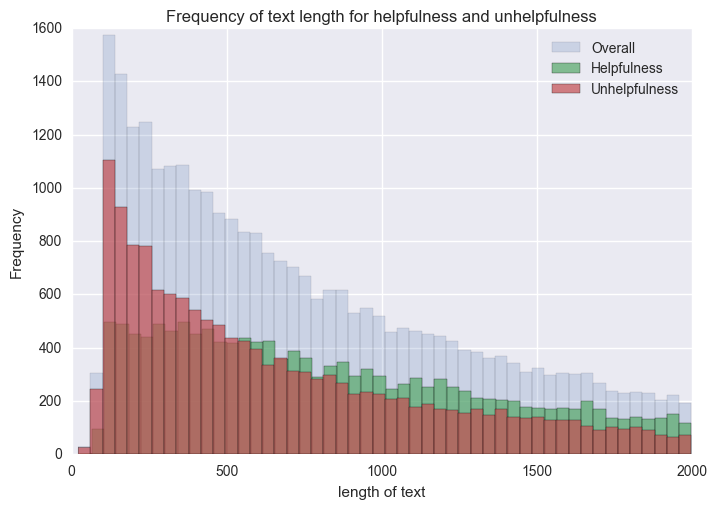

In [18]:
##########################
## 3.3 TEXT LENGTH  
########################### 


subset_ABS_df.text_len[subset_ABS_df.text_len<2000].plot(bins=50, kind='hist',alpha=0.2)
dhelp = subset_ABS_df.text_len[(subset_ABS_df['helpIndx']=='helpful') & (subset_ABS_df.text_len<2000)]
dunhelp = subset_ABS_df.text_len[(subset_ABS_df['helpIndx']=='unhelpful') & (subset_ABS_df.text_len<2000)]

dhelp.plot(bins=50, kind='hist', alpha=0.7)
dunhelp.plot(bins=50, kind='hist',alpha=0.7)

plt.legend(['Overall', 'Helpfulness', 'Unhelpfulness'])
plt.xlabel("length of text")
plt.ylabel("Frequency")
plt.title("Frequency of text length for helpfulness and unhelpfulness")
plt.show()


### ==> when text is shorter (<500), customers treat the reveiw text is unhelpful 

In [19]:
############################
## 3.4 PAIRWISE PEARSON CORR  
########################### 
names = ['reviewRating','help_prop','helpful_vot','text_len','tot_vot','helpIndx']
data = subset_ABS_df[names]
data[['helpIndx']] = np.where(data['helpIndx'] == 'helpful', 1, 0)
set_option('display.width', 100)
set_option('precision', 3)
correlations = data.corr(method='pearson')
print "================="
print(correlations)
print "================="

              reviewRating  help_prop  helpful_vot  text_len  tot_vot  helpIndx
reviewRating         1.000      0.312       -0.017     0.005   -0.086     0.269
help_prop            0.312      1.000        0.126     0.137    0.032     0.826
helpful_vot         -0.017      0.126        1.000     0.152    0.969     0.151
text_len             0.005      0.137        0.152     1.000    0.148     0.111
tot_vot             -0.086      0.032        0.969     0.148    1.000     0.075
helpIndx             0.269      0.826        0.151     0.111    0.075     1.000


### ==> weak correlation (0.3) between 'review rating' and 'helpful proportion'
### ==> weak correlation (0.1) between 'text length' and 'helpful proportion'
### ==> High correlation (0.9) between 'helpful vote' and 'total vote', that is, if more customers read the review text, more customers treat the review text as helpful

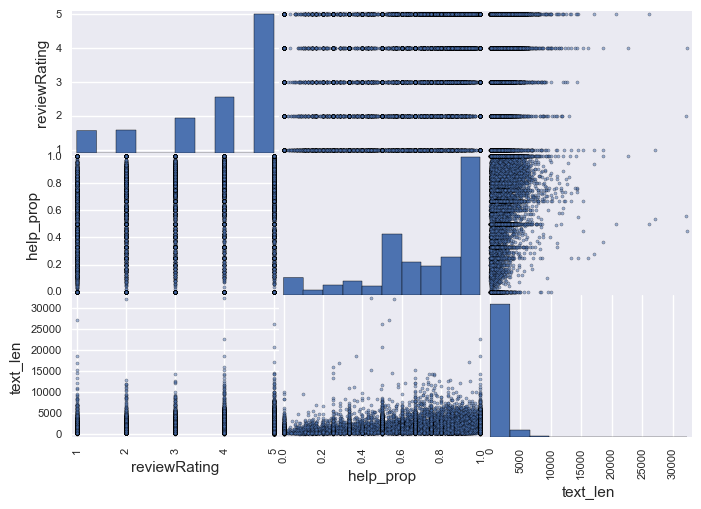

In [20]:
# scatter plot matrix
from pandas.tools.plotting import scatter_matrix
names = ['reviewRating','help_prop','text_len','helpIndx']
data = subset_ABS_df[names]
scatter_matrix(data)
plt.show()

----------
## _4. Bag of words_
### 4.1 Function to clean reviews to words
    * replaces all punctuation with spaces
    * converts the input string to lower case
    * splits the string to words
    * removes stop-words
### 4.2 Process to clean review
### 4.3 Manipulate clean text to be string instead of list (for count vectorize)
### 4.4 Extract features from strings
### 4.5 Transform a count matrix to tf-idf representation
### 4.6 Indentify top 20 features
### 4.7 word cloud of top 100 features

In [21]:
##########################################
## 4.1 FUNCTION TO CLEAN REVIEWS TO WORDS
##########################################

import re, string, nltk
from nltk.corpus import stopwords
    
def review2words(raw_review):
    remove = string.punctuation
    # keep surprise characters
    remove = remove.replace("!", "") # don't remove !
    remove = remove.replace("?", "") # don't remove ?
    pattern = r"[{}]".format(remove) # create the pattern

    # 1. replaces punctuation with spaces
    review_words=raw_review.str.replace(pattern, "")

    # 2. converts the input string to lower case
    review_words_low = review_words.str.lower()

    # 3. splits the string and ? ! to words 
    review_words_low2 = review_words_low.apply(nltk.word_tokenize)
    
    # 4. removes stop-words
    stops = set(stopwords.words("english")) # searching a set is faster than a list
    meaningful_words = review_words_low2.apply(lambda x: [w for w in x if w not in stops])    
    
    ## if necessary to do following clean text ##
    # 5. Stemming - strip off affixes
    # porter = nltk.PorterStemmer()
    # meaningful_words2 = meaningful_words.apply(lambda x: [porter.stem(t) for t in x])
    
    # 6. Lemmatizing - the word is from a dictionary 
    # wnl = nltk.WordNetLemmatizer()
    # clean_words = meaningful_words2.apply(lambda x: [wnl.lemmatize(t) for t in x])
    
    return(meaningful_words)


In [22]:
##########################################
## 4.2 PROCESS TO CLEAN REVIEWS TO WORDS
##########################################
clean_s = review2words(subset_ABS_df.reviewText)
clean_s.name="cleanText"
clean_s[:3]
## merge back to dataframe
# clean_ABS_df = pd.concat([ABS_df,clean_s],axis=1)
# clean_ABS_df.head(3)

2    [got, seventy, six, per, cent, book, couldnt, ...
3    [thought, story, really, well, told, totally, ...
8    [latest, book, former, president, jimmy, carte...
Name: cleanText, dtype: object

In [23]:
###############################################################################
## 4.3 MANIPULATE CLEAN TEXT TO BE STRING INSTEAD OF LIST (FOR count vectorize)
###############################################################################
def make_string(text):
    final_review_text = []
    for review in text:
        for word in review:
            n = review.index(word)
            if n == 0:
                string = review[n]
            else:
                string = string + " " + review[n]
        final_review_text.append(string)
    return final_review_text

final_text = make_string(clean_s)

In [24]:
####################################
## 4.4 EXTRACT FEATURES FROM STRING
####################################
## generate single words along with 2 and 3 word phrases, 
## select max 5000 terms 

from scipy.sparse import coo_matrix, vstack
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(binary=False, ngram_range=(1, 3), max_features = 5000,
                             token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'") # keep ? and !

# call `fit` to build the vocabulary
tfidf_review_text = vectorizer.fit_transform(final_text)
feature_names = vectorizer.get_feature_names()


print "================================================"
print "Number of features:", len(feature_names)
print "Ten words for each feature:", feature_names[0:10]
print "================================================"
# vectorizer.vocabulary_

Number of features: 5000
Ten words for each feature: [u'!', u'! !', u'! ! !', u'! ?', u'! also', u'! book', u'! cant', u'! cant wait', u'! dont', u'! great']


In [25]:
########################################
## 4.5 TRANSFORM A COUNT MATRIX TO A TF
########################################

from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()

# call `transform` to convert text to a bag of words
tfidf_matrix = transformer.fit_transform(tfidf_review_text) 

print "================================================"
print 'sparse matrix shape:', tfidf_matrix.shape # one row per review, one column per phrase
print 'number of non-zeros:', tfidf_matrix.nnz
print 'sparsity: %.2f%%' % (100.0 * tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))
print "================================================"

sparse matrix shape: (34812, 5000)
number of non-zeros: 1918619
sparsity: 1.10%


In [26]:
### convert CountVectorizer to density 
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])
review_dense = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(review_dense)), review_dense)]
#len(phrase_scores)

In [27]:
############################################################################
## 4.6 IDENTIFY TOP 20 INFORMATIVE FEATURES AND THEIR INVERSE DOCUMENT FREQ
############################################################################

top_numbers = 100
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
top_words = []
top_score = []
top =[]
for phrase, score in [(feature_names[word_id], score) 
    for (word_id, score) in sorted_phrase_scores][:top_numbers]:
        #print('{0: <20} {1}'.format(phrase, round(score,5)))
        top.append({'Feature_Name':phrase, 'Score':score})
        top_words.append(phrase)
        top_score.append(int(score*100))

print pd.DataFrame(top)[:20]


     Feature_Name  Score
0    descriptions  0.258
1           novel  0.257
2         looking  0.190
3          sophie  0.189
4             man  0.183
5          brains  0.179
6      book reads  0.178
7    book couldnt  0.176
8           dance  0.176
9   romance novel  0.174
10        schools  0.163
11           teen  0.160
12        holding  0.159
13      evolution  0.159
14            per  0.159
15          grown  0.156
16     reads like  0.156
17  psychological  0.154
18      direction  0.148
19            way  0.143


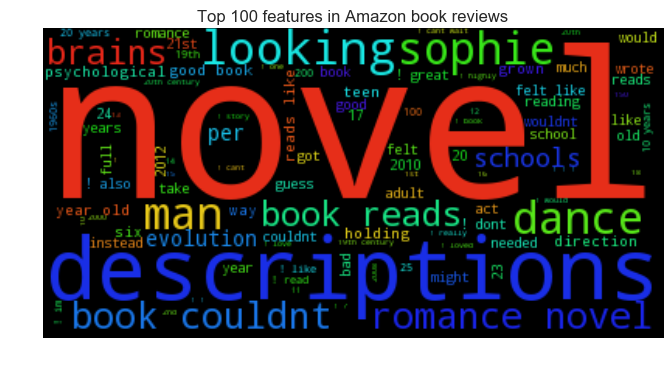

(0.0, 1.0, 0.0, 1.0)

In [29]:
############################################
## 4.7 PLOT WORDCLOUD OF TOP 100 FEATURES
############################################

### need wordcloud package by Andreas Mueller
### need Python’s imaging library PIL

top_wordDict = dict(zip(top_words, top_score))

from wordcloud import WordCloud
#wordcloud.generate_from_frequencies(dictionary.items())
wordcloud_fig = WordCloud().generate_from_frequencies(top_wordDict.items())

#plt.figure(1)
plt.imshow(wordcloud_fig)
plt.title("Top 100 features in Amazon book reviews")
plt.show()
plt.axis('off')

## _5. Machine Learning model_
### 5.1 Set custom features to model parameters
    * review rating (1 to 5)
    * length of review text
    * hyperparameters in a review text
### 5.2 Build models
    * linear
        Logistic Regression (LR)
        Linear Discriminant Analysis (LDA)
        Multinomial Naive Bayes (MNB)
    * nonlinear
        k-Nearest Neighbors (KNN)
        Classification and Regression Trees (DTC)
        Support Vector Machines (SVC)
        Random Forest Classifer (RFC)
        
### 5.3 Split data into train and test
    * helpful index (helpful vs. unhelpful) as prediction target 

### 5.4 Train models and identify the best model
    * use 10-fold cross validation to estimate accuracy

### 5.5 Classification report of the best model

### 5.6 Improve the best model by using grid search

### 5.7 Compare to the baseline model  
    * randomize x_train and x_test

In [36]:
warnings.filterwarnings('ignore')

from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split, KFold 
from sklearn.pipeline import Pipeline, FeatureUnion

In [31]:
#################################################
## 5.1 SET CUSTOMER FEATURES TO MODEL PARAMETERS
################################################

class TextExtractor:
      def __init__(self, column):
        self.column = column

      def transform(self, data):
        return np.asarray(data[self.column]).astype(str)

      def fit(self, *_):
        return self

class LengthVectorizer:
      VEC_LEN = np.vectorize(len)

      def transform(self, data):
        return self.VEC_LEN(data).astype(float)

      def fit(self, *_):
        return self;

class ArrayUpDimension:
      def transform(self, data):
        return data.reshape((data.shape[0], 1))

      def fit(self, *_):
        return self


class RatingExtractor:
      def __init__(self, column):
        self.column = column

      def transform(self, data):
        return np.asarray(data[self.column]).astype(int)

      def fit(self, *_):
        return self
    

In [32]:
### Our features include: ReviewRating, Length of ReviewText, useful phrase in ReviewText
## combine all features

desc_rating_featurizer = Pipeline([
  ('desc_extractor',  RatingExtractor('reviewRating')),
  ('scaler',          StandardScaler()),
  ('updim_array',     ArrayUpDimension())
])


desc_length_featurizer = Pipeline([
  ('desc_extractor',  TextExtractor('reviewText')),
  ('len_vectorizer',  LengthVectorizer()),
  ('scaler',          StandardScaler()),
  ('updim_array',     ArrayUpDimension())
])

desc_ngrams_featurizer = Pipeline([
  ('desc_extractor',    TextExtractor('reviewText')),
  ('count_vectorizer',  CountVectorizer(binary=False, ngram_range = (1, 3), 
                                        max_features = 5000,
                                        token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")),
  ('tfidf_transformer', TfidfTransformer())
])

# summary_ngrams_featurizer = Pipeline([
#   ('summary_extractor', TextExtractor('summary')),
#   ('count_vectorizer',  CountVectorizer(binary=False, ngram_range = (1, 3),min_df = 0.001,
#                              token_pattern=r"(?u)\b\w\w+\b|!|\?|\"|\'")),
#   ('tfidf_transformer', TfidfTransformer())
# ])

features = FeatureUnion([
  ('desc_rating_featurizer',  desc_rating_featurizer),
  ('desc_length_featurizer',  desc_length_featurizer),
  ('desc_tfidf_ngrams',       desc_ngrams_featurizer)
  #('summary_tfidft_ngrams',   summary_ngrams_featurizer)
])


In [33]:
#########################
## 5.2 BUILD MODELS
#########################
## import models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB


predictor_LR = LogisticRegression()
predictor_LDA = LinearDiscriminantAnalysis()
predictor_MNB = MultinomialNB()
predictor_KNN = KNeighborsClassifier()
predictor_SVC = LinearSVC()
predictor_DTC = DecisionTreeClassifier()
predictor_RFC = RandomForestClassifier()


pipeline_LR = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_LR)
])

pipeline_LDA = Pipeline([
  ('feature_union',  features),
  ('funtrans', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),     
  ('predictor', predictor_LDA)
])

pipeline_MNB = Pipeline([
  ('feature_union',  features),
  ('funtrans', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),        
  ('predictor', predictor_MNB)
])
pipeline_KNN = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_KNN)
])


pipeline_SVC = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_SVC)
])


pipeline_DTC = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_DTC)
])

pipeline_RFC = Pipeline([
  ('feature_union',  features),
  ('predictor', predictor_RFC)
])


In [34]:
#############################################
## 5.3 SPLIT TEXT INTO TRAIN AND VALIDATION
#############################################

# split data into train and validation
X = subset_ABS_df[['reviewRating','reviewText']]
Y = subset_ABS_df['helpIndx']

validation_size = 0.20
seed = 123
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
    test_size=validation_size, random_state=seed)


In [37]:
#############################################
## 5.4 TRAIN MODELS WITH CROSS VALIDATIAON
#############################################
warnings.filterwarnings('ignore')

## check running time
import timeit
start_time = timeit.default_timer()

## put all models in a main model
models = []
models.append(('LR', pipeline_LR))
models.append(('LDA', pipeline_LDA))
models.append(('MNB', pipeline_KNN))
models.append(('KNN', pipeline_KNN))
models.append(('SVC', pipeline_SVC))
models.append(('DTC', pipeline_DTC))
models.append(('RFC', pipeline_RFC))


results = []
names = []
for name, model in models:
    kf = KFold(X_train.shape[0], n_folds=5, random_state=seed) 
    cv_results = cross_val_score(model, 
                                 X_train, 
                                 Y_train, 
                                 cv=kf, 
                                 scoring='accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print msg
    
elapsed = timeit.default_timer() - start_time

print "running time (sec):", elapsed

LR: 0.636971 (0.004396)
LDA: 0.595353 (0.004723)
MNB: 0.597795 (0.004199)
KNN: 0.597795 (0.004199)
SVC: 0.613200 (0.005039)
DTC: 0.563001 (0.008994)
RFC: 0.590542 (0.004832)
running time (sec): 6007.80289698


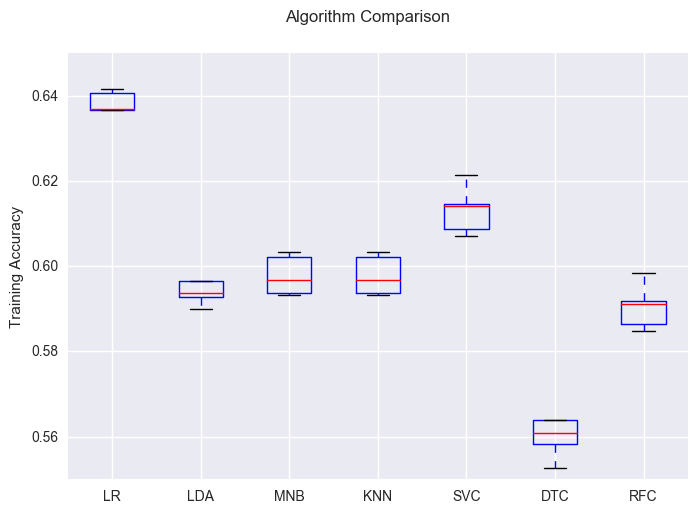

In [39]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111)
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.ylabel("Training Accuracy")
plt.show()

### ==> The result suggest that "Logistic Regression" is the best model to predict helpfulness of review text

In [40]:
###############################################
## 5.5 CLASSIFICATION REPORT OF THE BEST MODEL
###############################################

# Make predictions on validation dataset
FinalModel = pipeline_LR
FinalModel.fit(X_train, Y_train)
predictions = FinalModel.predict(X_validation)

print "==============================================="
print "LR"
print accuracy_score(Y_validation, predictions)
print confusion_matrix(Y_validation, predictions)
print classification_report(Y_validation, predictions)
print "==============================================="

LR
0.641102972857
[[2486 1088]
 [1411 1978]]
             precision    recall  f1-score   support

    helpful       0.64      0.70      0.67      3574
  unhelpful       0.65      0.58      0.61      3389

avg / total       0.64      0.64      0.64      6963



In [85]:
###################################################
## 5.6 IMPROVE THE PERFORMANCE OF THE BEST MODEL
##################################################


In [41]:
#########################################
## 5.7 RANDOMIZE X_train and X_validation
#########################################
rand_X_train = X_train.iloc[np.random.permutation(len(X_train))].reset_index(drop=True)
rand_X_validation = X_validation.iloc[np.random.permutation(len(X_validation))].reset_index(drop=True)


In [49]:
### Used best model to train randomize data
### calculate accuracy for randomize training data

kf = KFold(X_train.shape[0], n_folds=5, random_state=seed)
base_results = cross_val_score(pipeline_LR, 
                             rand_X_train, 
                             Y_train, 
                             cv=kf, 
                             scoring='accuracy') 

In [48]:
print "Training Accuracy for randomized data : %f (%f)" % (base_results.mean(), base_results.std())

randomized Data Training Accuracy: 0.503860 (0.008087)


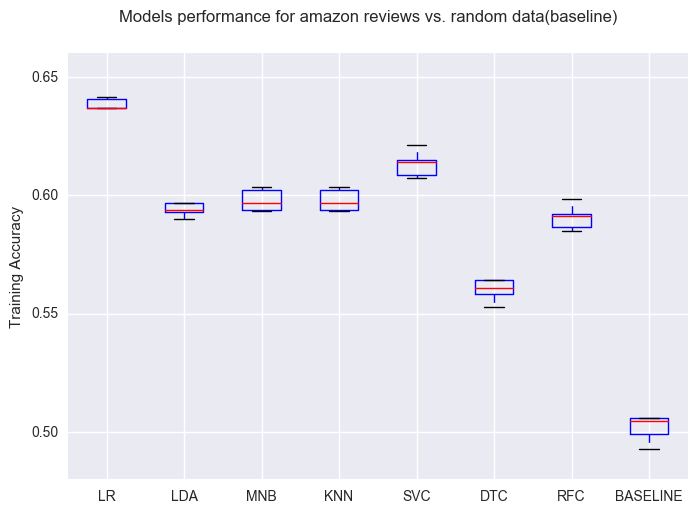

In [71]:
# Compare Algorithms with baseline model

results_with_baseline = results + [base_results]
names_with_baseline = names + ['BASELINE']

fig = plt.figure() 
fig.suptitle('Models performance for amazon reviews vs. random data(baseline)') 
ax = fig.add_subplot(111)
plt.boxplot(a) 
ax.set_xticklabels(b) 
plt.ylabel("Training Accuracy")
plt.show()

### ==> LR model has 64% accuracy to predict whether a review text is helpfulness based on review rating, length of text and review text. Randomize data can not provide any information to predict helpfulness

In [70]:
## test randomized model for prediction
BaseModel = pipeline_LR

BaseModel.fit(rand_X_train, Y_train)
Base_predictions = BaseModel.predict(rand_X_validation)

print "==============================================="
print "Baseline"
print accuracy_score(Y_validation, Base_predictions)
print confusion_matrix(Y_validation, Base_predictions)
print classification_report(Y_validation, Base_predictions)
print "==============================================="

Baseline
0.505241993394
[[1982 1592]
 [1853 1536]]
             precision    recall  f1-score   support

    helpful       0.52      0.55      0.54      3574
  unhelpful       0.49      0.45      0.47      3389

avg / total       0.50      0.51      0.50      6963



## 6. Conclusion and Future Direction


### In this project, we used reviewer rating, length of review text and features in texts to build a classify. Then, we train multiple linear and nonlinear algorithms and evaluated them by using cross validation. We found that "logistic regression" is the best algorithm to accurately predict the helpfulness of a review text (64%) compared to the baseline (50%). 

### Due to the limitation of current equipment, the result is based on a small review data set (1%) of Amazon Book Reviews. In the future, it is necessary to include whole data to estiablish the complete model. 
    * identify necessary 
    * consider other features, such as misspelling, length of sentences, and  
    * observe the best parameters of the model
### In the future, the classifying systems should not only predict helpfulness of a review text, it should also extract useful terms based on reviews of similar products. These information are more important for customers of online shopping. 